<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/main/13-GANs/GAN_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Modify snippets below and implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with weight clipping. (2 points)

* Replace  weight clipping with [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (2 points)

* Add labels into WGAN, performing [conditional generation](https://arxiv.org/pdf/1411.1784.pdf). (2 points)

Write a report about experiments and results, add plots and visualizations.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 17380005.37it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 330951.92it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2057999.71it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15120642.15it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
DEVICE = 'cpu'

In [9]:
def plot_wgan_loss(errd_x, errd_z, errg):
    plt.plot(errd_x, label='critic (real)')
    plt.plot(errd_z, label='critic (fake)')
    plt.plot(errg, label='generator')
    plt.title('WGAN loss')
    plt.legend()

### Create generator and discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [10]:
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

### Create optimizers and loss

In [11]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [16]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28)).to(DEVICE)
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(DEVICE)
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)).to(DEVICE)
label = Variable(torch.FloatTensor(config.batch_size)).to(DEVICE)
real_label = 1
fake_label = 0

### GAN

In [17]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        images, cat = images.to(DEVICE), cat.to(DEVICE)

        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data).flatten()
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).flatten()
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).flatten()
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                epoch+1,
                iteration+1,
                errD_x.item(),
                errD_z.item(),
                errG.item())
            )

Epoch:1 Iter: 100 errD_x: 0.16 errD_z: 0.15 errG: 2.05
Epoch:1 Iter: 200 errD_x: 0.15 errD_z: 0.10 errG: 2.63
Epoch:1 Iter: 300 errD_x: 0.19 errD_z: 0.12 errG: 2.51
Epoch:1 Iter: 400 errD_x: 0.18 errD_z: 0.21 errG: 1.87
Epoch:1 Iter: 500 errD_x: 0.05 errD_z: 0.09 errG: 2.77
Epoch:1 Iter: 600 errD_x: 0.03 errD_z: 0.05 errG: 3.12
Epoch:1 Iter: 700 errD_x: 0.12 errD_z: 0.09 errG: 2.91
Epoch:1 Iter: 800 errD_x: 0.25 errD_z: 0.10 errG: 2.48
Epoch:1 Iter: 900 errD_x: 0.02 errD_z: 0.13 errG: 2.46
Epoch:1 Iter: 1000 errD_x: 0.13 errD_z: 0.18 errG: 2.23
Epoch:1 Iter: 1100 errD_x: 0.27 errD_z: 0.10 errG: 2.77
Epoch:1 Iter: 1200 errD_x: 0.17 errD_z: 0.16 errG: 2.11
Epoch:1 Iter: 1300 errD_x: 0.41 errD_z: 0.14 errG: 2.27
Epoch:1 Iter: 1400 errD_x: 0.19 errD_z: 0.19 errG: 2.01
Epoch:1 Iter: 1500 errD_x: 0.06 errD_z: 0.18 errG: 2.66
Epoch:1 Iter: 1600 errD_x: 0.16 errD_z: 0.13 errG: 2.80
Epoch:1 Iter: 1700 errD_x: 0.06 errD_z: 0.19 errG: 2.48
Epoch:1 Iter: 1800 errD_x: 0.25 errD_z: 0.16 errG: 2.56
E

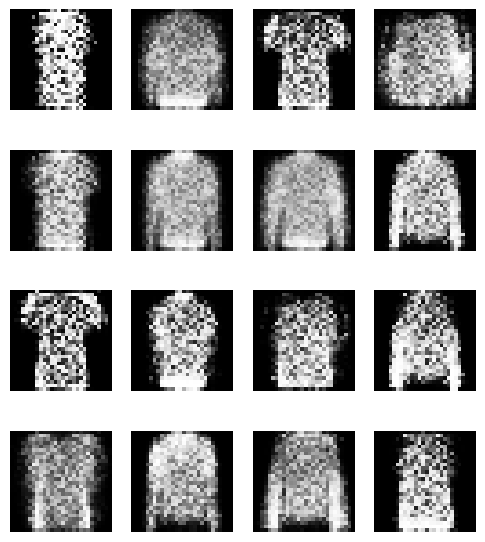

In [19]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN with weight clipping

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Tanh())

    def forward(self, x):
        return self.model(x)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )
    def forward(self, x):
        return self.model(x)

In [21]:
generator = Generator().to(DEVICE)
critic = Critic().to(DEVICE)

optim_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optim_C = optim.RMSprop(critic.parameters(), lr=0.00005)

input = Variable(torch.FloatTensor(config.batch_size, 28*28)).to(DEVICE)
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(DEVICE)
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)).to(DEVICE)

In [22]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
clip_value = 0.01

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Critic stage: maximize E[D(x)] - E[D(G(z))]
        #######
        images, cat = images.to(DEVICE), cat.to(DEVICE)

        for _ in range(5):
            critic.zero_grad()

            # real
            input_data = images.view(images.shape[0], -1)
            real_loss = torch.mean(critic(input_data))

            # fake
            noise.data.normal_(0, 1)
            fake = generator(noise)
            fake_loss = torch.mean(critic(fake.detach()))

            # critic loss
            loss_critic = fake_loss - real_loss
            ERRD_x[epoch] += real_loss.item()
            ERRD_z[epoch] += fake_loss.item()
            loss_critic.backward()

            optim_C.step()

            # weight clipping
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        #######
        # Generator stage: minimize -E[D(G(z))]
        #######
        generator.zero_grad()
        noise.data.normal_(0, 1)
        fake = generator(noise)
        loss_generator = -torch.mean(critic(fake))
        ERRG[epoch] += loss_generator.item()
        loss_generator.backward()

        optim_G.step()

        if (iteration + 1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                epoch+1,
                iteration+1,
                ERRD_x[epoch] / (iteration + 1),
                ERRD_z[epoch] / (iteration + 1),
                ERRG[epoch] / (iteration + 1))
            )

Epoch:1 Iter: 100 errD_x: 1.32 errD_z: 0.92 errG: -0.18
Epoch:1 Iter: 200 errD_x: 0.95 errD_z: 0.71 errG: -0.14
Epoch:1 Iter: 300 errD_x: 0.69 errD_z: 0.38 errG: -0.08
Epoch:1 Iter: 400 errD_x: 0.55 errD_z: 0.21 errG: -0.04
Epoch:1 Iter: 500 errD_x: 0.47 errD_z: 0.14 errG: -0.03
Epoch:1 Iter: 600 errD_x: 0.42 errD_z: 0.11 errG: -0.02
Epoch:1 Iter: 700 errD_x: 0.39 errD_z: 0.11 errG: -0.02
Epoch:1 Iter: 800 errD_x: 0.78 errD_z: 0.44 errG: -0.09
Epoch:1 Iter: 900 errD_x: 0.74 errD_z: 0.42 errG: -0.08
Epoch:1 Iter: 1000 errD_x: 0.65 errD_z: 0.31 errG: -0.06
Epoch:1 Iter: 1100 errD_x: 0.59 errD_z: 0.25 errG: -0.05
Epoch:1 Iter: 1200 errD_x: 0.55 errD_z: 0.22 errG: -0.04
Epoch:1 Iter: 1300 errD_x: 0.51 errD_z: 0.19 errG: -0.04
Epoch:1 Iter: 1400 errD_x: 0.47 errD_z: 0.18 errG: -0.03
Epoch:1 Iter: 1500 errD_x: 0.61 errD_z: 0.28 errG: -0.05
Epoch:1 Iter: 1600 errD_x: 0.69 errD_z: 0.37 errG: -0.07
Epoch:1 Iter: 1700 errD_x: 0.67 errD_z: 0.36 errG: -0.07
Epoch:1 Iter: 1800 errD_x: 0.65 errD_z: 

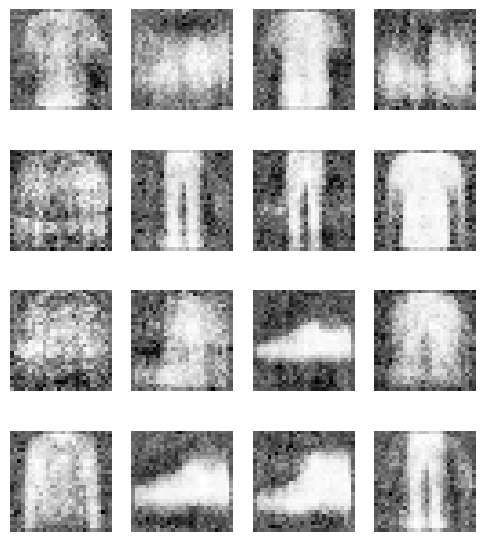

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

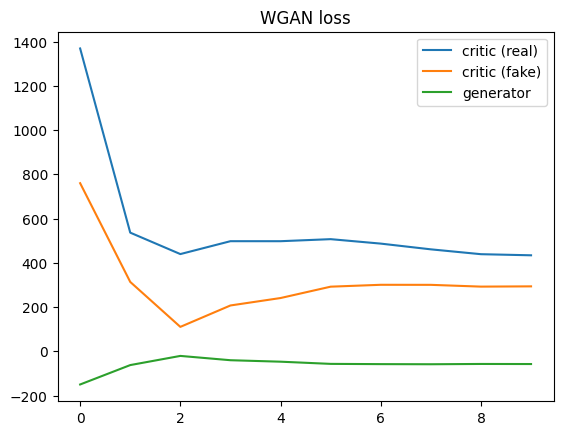

In [37]:
plot_wgan_loss(ERRD_x, ERRD_z,ERRG)

### WGAN with Gradient Penalty

In [45]:
generator = Generator().to(DEVICE)
critic = Critic().to(DEVICE)

optim_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optim_C = optim.RMSprop(critic.parameters(), lr=0.00005)

input = Variable(torch.FloatTensor(config.batch_size, 28*28)).to(DEVICE)
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(DEVICE)
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)).to(DEVICE)

In [46]:
from torch import autograd


ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
lambda_gp = 10


def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1).to(DEVICE)
    epsilon = epsilon.expand(real_data.size())

    interpolates = epsilon * real_data + (1 - epsilon) * fake_data
    interpolates = Variable(interpolates, requires_grad=True)

    critic_interpolates = critic(interpolates)

    gradients = autograd.grad(
        outputs=critic_interpolates, inputs=interpolates,
        grad_outputs=torch.ones(critic_interpolates.size()).to(DEVICE),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

for epoch in range(config.num_epochs):
    for iteration, (images, _) in enumerate(dataloader):
        #######
        # Critic stage: maximize E[D(x)] - E[D(G(z))] + Gradient Penalty
        #######
        images = images.to(DEVICE)

        for _ in range(5):
            critic.zero_grad()

            # Real data
            input_data = images.view(images.shape[0], -1)
            real_data = Variable(input_data)
            real_loss = torch.mean(critic(real_data))

            # Fake data
            noise.data.normal_(0, 1)
            fake = generator(noise).detach()
            fake_loss = torch.mean(critic(fake))

            # Gradient penalty
            gp = gradient_penalty(critic, real_data.data, fake.data)

            # Critic loss
            loss_critic = fake_loss - real_loss + gp
            ERRD_x[epoch] += real_loss.item()
            ERRD_z[epoch] += fake_loss.item()
            loss_critic.backward()

            optim_C.step()

        #######
        # Generator stage: minimize -E[D(G(z))]
        #######
        generator.zero_grad()
        noise.data.normal_(0, 1)
        fake = generator(noise)
        loss_generator = -torch.mean(critic(fake))
        ERRG[epoch] += loss_generator.item()
        loss_generator.backward()

        optim_G.step()

        if (iteration + 1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(
                epoch+1,
                iteration+1,
                ERRD_x[epoch] / (iteration + 1),
                ERRD_z[epoch] / (iteration + 1),
                ERRG[epoch] / (iteration + 1))
            )

Epoch:1 Iter: 100 errD_x: 40.19 errD_z: 20.40 errG: -4.05
Epoch:1 Iter: 200 errD_x: 34.29 errD_z: 21.94 errG: -4.36
Epoch:1 Iter: 300 errD_x: 26.24 errD_z: 15.60 errG: -3.10
Epoch:1 Iter: 400 errD_x: 24.21 errD_z: 12.29 errG: -2.44
Epoch:1 Iter: 500 errD_x: 23.04 errD_z: 10.22 errG: -2.03
Epoch:1 Iter: 600 errD_x: 22.79 errD_z: 9.13 errG: -1.81
Epoch:1 Iter: 700 errD_x: 22.97 errD_z: 8.78 errG: -1.74
Epoch:1 Iter: 800 errD_x: 23.09 errD_z: 8.69 errG: -1.72
Epoch:1 Iter: 900 errD_x: 23.17 errD_z: 8.81 errG: -1.75
Epoch:1 Iter: 1000 errD_x: 23.58 errD_z: 9.29 errG: -1.84
Epoch:1 Iter: 1100 errD_x: 23.85 errD_z: 9.64 errG: -1.91
Epoch:1 Iter: 1200 errD_x: 23.96 errD_z: 9.88 errG: -1.96
Epoch:1 Iter: 1300 errD_x: 23.98 errD_z: 9.99 errG: -1.99
Epoch:1 Iter: 1400 errD_x: 23.78 errD_z: 9.90 errG: -1.97
Epoch:1 Iter: 1500 errD_x: 23.37 errD_z: 9.62 errG: -1.91
Epoch:1 Iter: 1600 errD_x: 23.00 errD_z: 9.39 errG: -1.86
Epoch:1 Iter: 1700 errD_x: 22.49 errD_z: 9.03 errG: -1.79
Epoch:1 Iter: 1800

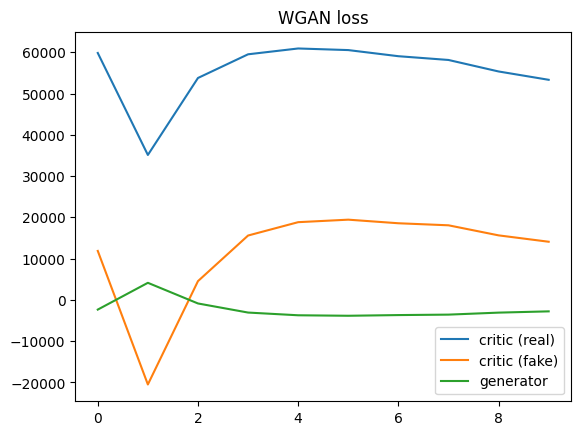

In [47]:
plot_wgan_loss(ERRD_x, ERRD_z,ERRG)

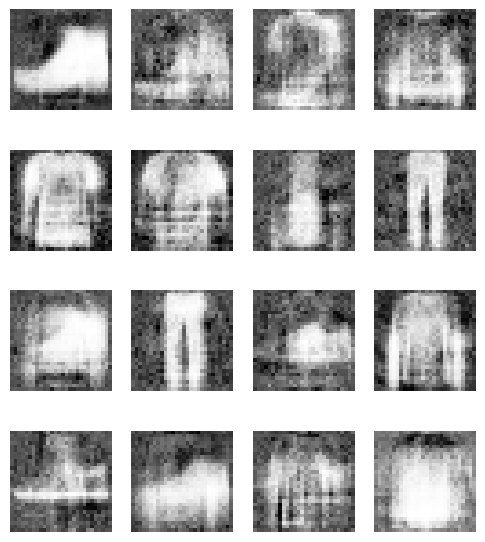

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN with conditional generation

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(config.noise_size + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_embedding(labels)
        x = torch.cat([noise, c], 1)
        return self.model(x)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)
        )

    def forward(self, img, labels):
        c = self.label_embedding(labels)
        x = torch.cat([img, c], 1)
        return self.model(x)


In [11]:
generator = Generator().to(DEVICE)
critic = Critic().to(DEVICE)

optim_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optim_C = optim.RMSprop(critic.parameters(), lr=0.00005)

input = Variable(torch.FloatTensor(config.batch_size, 28*28)).to(DEVICE)
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(DEVICE)
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1)).to(DEVICE)

In [12]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
clip_value = 0.01

for epoch in range(config.num_epochs):
    for iteration, (images, labels) in enumerate(dataloader):
        labels = labels.to(torch.long).to(DEVICE)
        images = images.to(DEVICE)
        #######
        # Critic stage: maximize E[D(x)] - E[D(G(z))]
        #######
        for _ in range(5):  # Train the critic 5 times more than the generator
            critic.zero_grad()

            # Real data
            input_data = images.view(images.shape[0], -1).to(torch.float32)
            real_data = Variable(input_data)
            real_loss = torch.mean(critic(real_data, labels))

            # Fake data
            noise.data.normal_(0, 1)
            fake_labels = Variable(torch.LongTensor(config.batch_size).random_(0, 10)).to(DEVICE)
            fake = generator(noise, fake_labels).detach()
            fake_loss = torch.mean(critic(fake, fake_labels))

            # Critic loss
            loss_critic = fake_loss - real_loss
            ERRD_x[epoch] += real_loss.item()
            ERRD_z[epoch] += fake_loss.item()
            loss_critic.backward()
            optim_C.step()

            # Weight clipping
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        #######
        # Generator stage: minimize -E[D(G(z))]
        #######
        generator.zero_grad()
        noise.data.normal_(0, 1)
        fake_labels = Variable(torch.LongTensor(config.batch_size).random_(0, 10)).to(DEVICE)
        fake = generator(noise, fake_labels)
        loss_generator = -torch.mean(critic(fake, fake_labels))
        ERRG[epoch] += loss_generator.item()
        loss_generator.backward()
        optim_G.step()

        if (iteration + 1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} Loss Critic: {:.2f} Loss Generator: {:.2f}'.format(
                epoch+1,
                iteration+1,
                loss_critic.item(),
                loss_generator.item())
            )


Epoch:1 Iter: 100 Loss Critic: -0.01 Loss Generator: -0.15
Epoch:1 Iter: 200 Loss Critic: 0.01 Loss Generator: 0.15
Epoch:1 Iter: 300 Loss Critic: -0.07 Loss Generator: 0.11
Epoch:1 Iter: 400 Loss Critic: -0.04 Loss Generator: 0.07
Epoch:1 Iter: 500 Loss Critic: -0.04 Loss Generator: 0.05
Epoch:1 Iter: 600 Loss Critic: -0.13 Loss Generator: -0.48
Epoch:1 Iter: 700 Loss Critic: -0.02 Loss Generator: 0.18
Epoch:1 Iter: 800 Loss Critic: -0.02 Loss Generator: -0.19
Epoch:1 Iter: 900 Loss Critic: -0.08 Loss Generator: 0.22
Epoch:1 Iter: 1000 Loss Critic: -0.09 Loss Generator: -0.12
Epoch:1 Iter: 1100 Loss Critic: -0.11 Loss Generator: -0.04
Epoch:1 Iter: 1200 Loss Critic: -0.06 Loss Generator: -0.06
Epoch:1 Iter: 1300 Loss Critic: -0.10 Loss Generator: -0.02
Epoch:1 Iter: 1400 Loss Critic: -0.06 Loss Generator: -0.06
Epoch:1 Iter: 1500 Loss Critic: -0.04 Loss Generator: -0.10
Epoch:1 Iter: 1600 Loss Critic: -0.02 Loss Generator: -0.09
Epoch:1 Iter: 1700 Loss Critic: -0.03 Loss Generator: -0

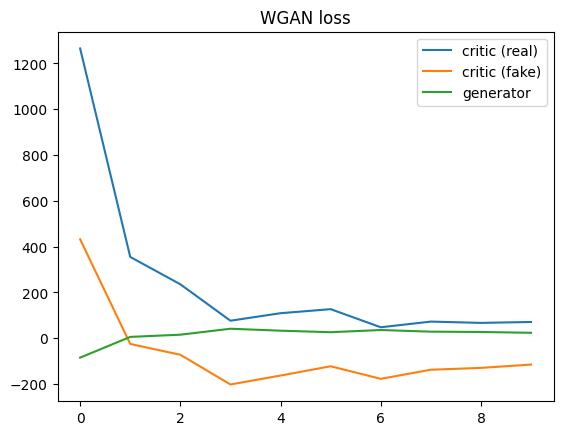

In [13]:
plot_wgan_loss(ERRD_x, ERRD_z,ERRG)

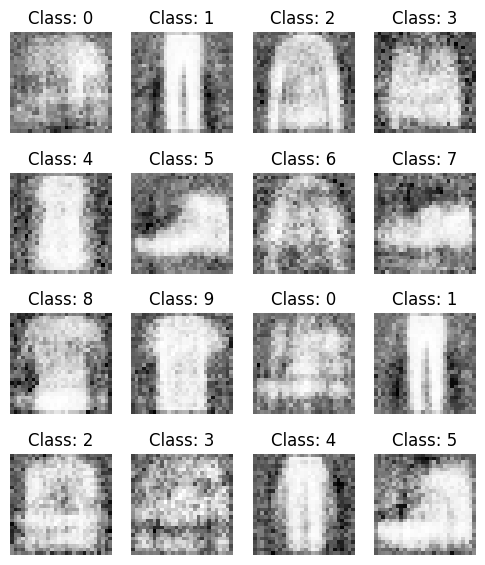

In [ ]:
noise = Variable(torch.FloatTensor(16, config.noise_size).normal_(0, 1))
labels = torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5])

fake_images = generator(noise, labels)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake_images[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')

Для всех моделей удалось добиться сбалансированного изменения функции потерь генератора и дискриминатора, при котором ни одна сильно не превышает другую, что дает возможность обеим моделям продолжать обучаться без оверфита и без скатывания в model collapse.